*08/14/24*
Authors: Ismael Mendoza

In [1]:
import jax 
import jax.numpy as jnp
from jax.scipy import stats

from jax import random
from jax import jit as jjit

In [2]:
import galsim 
import jax_galsim as xgalsim

2024-08-19 15:27:56.654392: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-08-19 15:28:26.686454: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import blackjax
import numpy as np 

import arviz as az
import chainconsumer as cc
import matplotlib.pyplot as plt

import numpyro
import time
from datetime import date

import matplotlib.pyplot as plt 

/pscratch/sd/i/imendoza/miniconda3/envs/bpd_gpu2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from tqdm import tqdm

In [5]:
from functools import partial

In [6]:
from blackjax.diagnostics import effective_sample_size, potential_scale_reduction

In [7]:
import bpd
from bpd.draw import add_noise
from bpd.measure import get_snr


In [48]:
from bpd.chains import inference_loop, inference_loop_multiple_chains

In [8]:
jax.devices()

[CudaDevice(id=0)]

In [9]:
GPU = jax.devices('gpu')[0]

In [10]:
jax.config.update("jax_enable_x64", True) # fair comparison with GalSim, among other reasons

# Drawing methods

In [133]:
# constant galaxy parameters to fit 
PIXEL_SCALE = 0.2
BACKGROUND = 1e4
SLEN= 53
PSF_HLR = 0.7

LOG_FLUX = 4.5
HLR = 0.9
G1 = 0.05
G2 = 0.0

TRUE_PARAMS = {'f': LOG_FLUX, 'hlr': HLR, 'g1': G1, 'g2': G2}

In [134]:
def _draw_gal():
    gal = galsim.Gaussian(flux=10**LOG_FLUX, half_light_radius=HLR)
    gal = gal.shear(g1=G1, g2=G2)
    
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf])
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 )
    return image.array

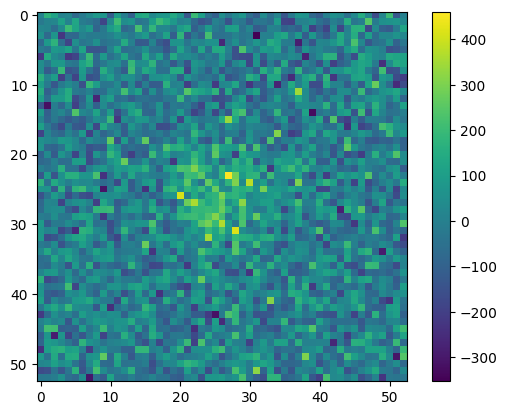

In [135]:
im_nn = _draw_gal()
im = add_noise(im_nn, BACKGROUND)[0] ## does not add background just noise
plt.imshow(im)
plt.colorbar()

In [136]:
print(get_snr(im_nn, BACKGROUND))

18.25107


In [137]:
from functools import partial
# jax drawing
GSPARAMS = xgalsim.GSParams(minimum_fft_size=256, maximum_fft_size=256)

def draw_gal(f, hlr, g1, g2):
    gal = xgalsim.Gaussian(flux=10**f, half_light_radius=hlr)
    gal = gal.shear(g1=g1, g2=g2)
    
    psf = xgalsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = xgalsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 )
    return image.array

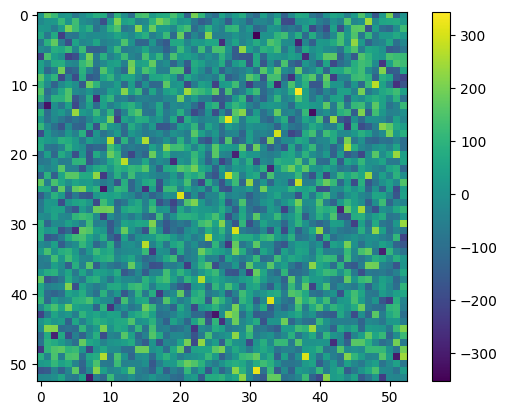

In [138]:
# sanity check 1
res = im - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

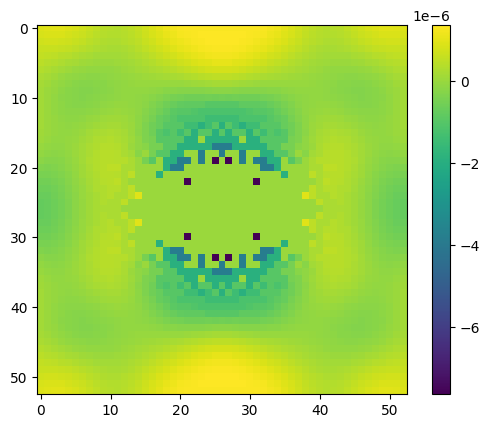

In [139]:
# sanity check 2
res = im_nn - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

In [140]:
# # timing makes sense
# draw_gal_jitted = jax.jit(draw_gal)
# draw_gal_jitted(**TRUE_PARAMS)

# %timeit draw_gal_jitted(**TRUE_PARAMS) # ~ twice fast
# %timeit _draw_gal()

173 μs ± 3.03 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
424 μs ± 1.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Setup logprob

In [141]:
TRUE_PARAMS_GPU = jax.device_put(TRUE_PARAMS, device=GPU)
BACKGROUND_GPU = jax.device_put(BACKGROUND, device=GPU)
BOUNDS = {'f': (4., 5.), 'hlr': (0.7, 1.2), 'g1': (-0.1, 0.1), 'g2': (-0.1, 0.1)
}
BOUNDS_GPU = jax.device_put(BOUNDS, device=GPU)

In [142]:
def transform_func(params):
    """Every variable is assumed to be uniform between (0,1)"""
    new = {} 
    for p in params:
        new[p] = params[p] * + BOUNDS_GPU[p][0]
    return new

def inv_transform_func(params):
    """Every variable is assumed to be uniform between (0,1)"""
    new = {} 
    for p in params:
        new[p] = (params[p] - BOUNDS_GPU[p][0]) / (BOUNDS_GPU[p][1] - BOUNDS_GPU[p][0]) 
    return new

def _logprob_fn(params, data):
    f = params['f']
    hlr = params['hlr']
    g1 = params['g1'] 
    g2 = params['g2'] 
    
    #prior
    prior = jax.device_put(0.,device=GPU) 
    for p in params:
        b1, b2 = BOUNDS_GPU[p]
        prior += stats.uniform.logpdf(params[p], b1, b2-b1)

    # likelihood
    model = draw_gal(**params)
    likelihood = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(BACKGROUND_GPU))
    
    return jnp.sum(prior) + jnp.sum(likelihood)

def _logprob_fn_transform(std_params, data):
    params = transform_func(std_params)
    
    #prior
    prior = jax.device_put(0.,device=GPU) 
    for p in params:
        prior += stats.uniform.logpdf(std_params[p], 0, 1)

             
    # likelihood
    model = draw_gal(**params)
    likelihood = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(BACKGROUND_GPU))
    
    return jnp.sum(prior) + jnp.sum(likelihood)

# Blackjax NUTS

In [340]:
from bpd.chains import inference_loop

## Warmup and divergences

In [341]:
data = add_noise(_draw_gal(), BACKGROUND, 
                 rng=np.random.default_rng(44), n=1)[0]
data_gpu = jax.device_put(data, device=GPU)
data_gpu.devices(), type(data_gpu), data_gpu.shape

({CudaDevice(id=0)}, jaxlib.xla_extension.ArrayImpl, (53, 53))

In [342]:
logdensity = jjit(partial(_logprob_fn, data=data_gpu) )

In [343]:
seed = jax.random.key(42)
seed = jax.device_put(seed, device=GPU)
seed.devices()

{CudaDevice(id=0)}

In [344]:
_, warmup_key, sample_key = jax.random.split(seed, 3)

In [345]:
warmup = blackjax.window_adaptation(
    blackjax.nuts, logdensity, progress_bar=False, is_mass_matrix_diagonal=False
)

In [346]:
init_positions = {**TRUE_PARAMS_GPU}

In [347]:
%%time
(init_states, tuned_params), adapt_info = warmup.run(warmup_key, init_positions, 1000)

CPU times: user 12.3 s, sys: 205 ms, total: 12.5 s
Wall time: 13.4 s


In [120]:
adapt_info.info.is_divergent.sum()

Array(885, dtype=int64)

# Blackjax Barker

In [143]:
from blackjax.adaptation.step_size import find_reasonable_step_size


## Warmup and acceptance rate

In [144]:
#data 
SEED = 53
data = add_noise(_draw_gal(), BACKGROUND, 
                 rng=np.random.default_rng(SEED),
                 n=1)[0]
data_gpu = jax.device_put(data, device=GPU)
print(data_gpu.devices(), type(data_gpu), data_gpu.shape)

#key
rng_key = jax.random.key(SEED)
rng_key = jax.device_put(rng_key, device=GPU)
print(rng_key.devices())

{CudaDevice(id=0)} <class 'jaxlib.xla_extension.ArrayImpl'> (53, 53)
{CudaDevice(id=0)}


In [145]:
_, warmup_key, sample_key  = random.split(rng_key, 3)

In [146]:
init_positions = {**TRUE_PARAMS_GPU}

In [147]:
logdensity = jjit(partial(_logprob_fn, data=data_gpu) )

In [148]:
INIT_STEP_SIZE = 0.5
init_kernel = blackjax.barker.as_top_level_api(logdensity, step_size=INIT_STEP_SIZE)
init_state=init_kernel.init(init_positions)

In [149]:
def kernel_generator(step_size):
    return blackjax.barker.as_top_level_api(logdensity, step_size=step_size).step

In [150]:
%%time
tuned_step_size =find_reasonable_step_size(warmup_key, kernel_generator, reference_state=init_state, 
                                           target_accept=0.9, initial_step_size=INIT_STEP_SIZE)
tuned_step_size

CPU times: user 2.5 s, sys: 18.4 ms, total: 2.51 s
Wall time: 2.45 s


Array(0.03125, dtype=float64, weak_type=True)

In [151]:
%%time
states, info = inference_loop(sample_key, kernel_generator(tuned_step_size), init_state, n_samples=1000)

CPU times: user 2.47 s, sys: 61 ms, total: 2.53 s
Wall time: 2.47 s


(array([246.,  11.,  13.,   8.,  10.,  12.,   7.,   9.,  11.,  11.,   8.,
          5.,  10.,  13.,  11.,   8.,  13.,  19.,  13.,  21.,  21.,  19.,
         34.,  50., 417.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
        0.88, 0.92, 0.96, 1.  ]),
 [<matplotlib.patches.Polygon at 0x7f7e342a59f0>])

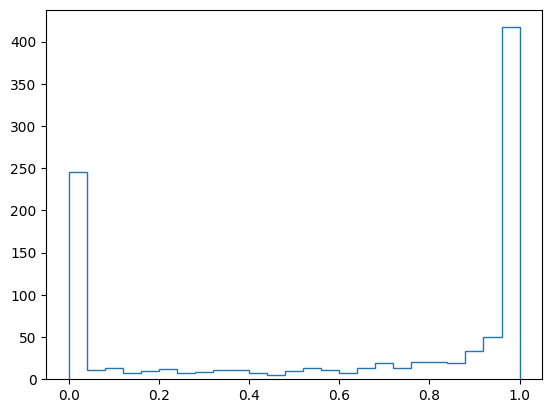

In [152]:
plt.hist(info.acceptance_rate, histtype='step', bins=25)

In [153]:
samples = states.position

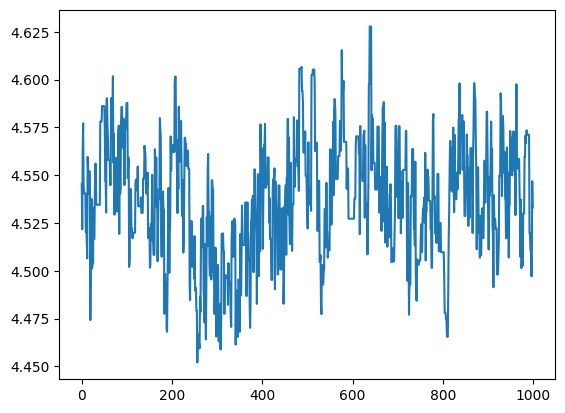

In [154]:
plt.plot(samples['f'])

## Run multiple barker chains simultaneously with same step_size on same noise realization

In [168]:
from bpd.chains import inference_loop_multiple_chains

In [169]:
N_CHAINS=10

In [157]:
#data 
SEED = 42
data = add_noise(_draw_gal(), BACKGROUND, 
                 rng=np.random.default_rng(SEED),
                 n=1)[0]
data_gpu = jax.device_put(data, device=GPU)
print(data_gpu.devices(), type(data_gpu), data_gpu.shape)

#key
rng_key = jax.random.key(SEED)
rng_key = jax.device_put(rng_key, device=GPU)
print(rng_key.devices())

{CudaDevice(id=0)} <class 'jaxlib.xla_extension.ArrayImpl'> (53, 53)
{CudaDevice(id=0)}


In [158]:
barker = blackjax.barker.as_top_level_api(logdensity, step_size=0.03125)
kernel = jjit(barker.step)

In [159]:
init_positions = {p:q*jnp.ones((N_CHAINS,)) for p,q in TRUE_PARAMS_GPU.items()}
init_positions['f'].shape

(100,)

In [160]:
init_states = jax.vmap(barker.init)(init_positions)

In [161]:
%%time
states, infos = inference_loop_multiple_chains(rng_key, kernel, init_states, 1000, N_CHAINS)

CPU times: user 8.19 s, sys: 29.1 ms, total: 8.22 s
Wall time: 6.68 s


In [162]:
samples = states.position

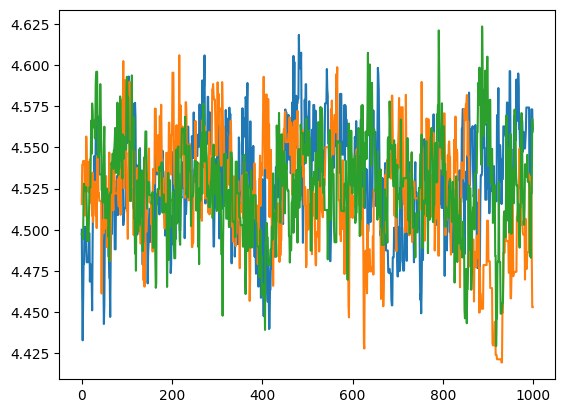

In [163]:
plt.plot(samples['f'][:, 0])
plt.plot(samples['f'][:, 5])
plt.plot(samples['f'][:, 21])

### ESS and autocorr

In [164]:
# ess
print('ess')
print()
for p in samples: 
    ess = effective_sample_size(samples[p], chain_axis=1 ,sample_axis=0)
    print(p, ess)
    print('rel: %', ess * 100 / samples[p].size)
    print()
    
print()
print('r-hat')
print()
for p in samples: 
    print(p, potential_scale_reduction(samples[p], chain_axis=1 ,sample_axis=0))


ess

f 3800.770902725813
rel: % 3.8007709027258127

g1 6066.893228570794
rel: % 6.066893228570795

g2 5774.121802261869
rel: % 5.7741218022618686

hlr 2463.296757900061
rel: % 2.463296757900061


r-hat

f 1.012110917780706
g1 1.0076470316104322
g2 1.0105437221170115
hlr 1.0195125604267652


In [165]:
az.ess(np.array(samples['f'].T)) # close enough to arviz

3845.2452618371212

In [166]:
aucorr = az.autocorr(np.array(samples['f'][:, 1]))
aucorr.shape

(1000,)

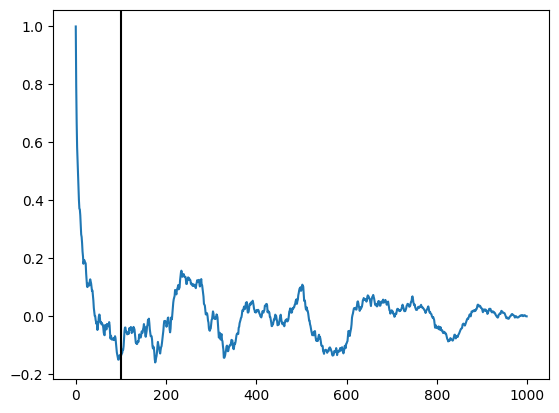

In [167]:
plt.plot(aucorr)
plt.axvline(100, color='k')

## Vmap adapt step size